In [1]:

import calendar

months = list(map(lambda x: x.lower(), calendar.month_name))[1:]
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)

import os

project_folder = f'{os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))}/data/process'
import warnings

warnings.filterwarnings(action='ignore')
from IPython.display import display
from IPython.display import Markdown
from IPython.display import display_html


questions ={'Q2':'part','Q6':'day_time','Q7':'is_locked','Q8':'locked_type','Q9':'theft_loc','Q10':'is_registered','Q11':'where_rep','Q12':'is_insured','Q13':'value_approx','Q14':'is_electric','Q15':'bicycle_type','Q17':'is_univ','Q18':'is_recover','Q19':'is_online','Q20':'how_recover','Q21':'is_police','Q23':'rec_loc','Q24':'rec_cond ','Q25':'is_replaced', 'Q26_new':'days_bikes', 'Q28':'seasons', 'Q29':'purpose', 'Q30':'mode_alt', 'Q31':'post_act','Q32':'why_less','age_groups': 'age', 'Q35': 'gender', 'Q36': 'income','Q37':'nm_bikes', 'Q38': 'education', 'Q39': 'ethnic','country':'country','city':'city'}

In [2]:
# That's not part of the procedure
pd.read_csv(f'{project_folder}/new_data/new_data.csv').reset_index().iloc[0].to_csv(
    'output_2/fileds_to_work_on.csv')

In [5]:
# show the questions
data_questions = pd.read_csv(f'{project_folder}/new_data/new_data.csv', skiprows=[2]).reset_index().iloc[0]
data_questions

index                                                          0
StartDate                                             Start Date
EndDate                                                 End Date
Status                                             Response Type
IPAddress                                             IP Address
                                     ...                        
Q38            What is the highest level of education you hav...
Q39            What do you consider your main ethnic origin o...
Q39_10_TEXT    What do you consider your main ethnic origin o...
Q40            Where did you hear about this survey? - Select...
Q40_3_TEXT     Where did you hear about this survey? - Other ...
Name: 0, Length: 75, dtype: object

#### Data Preparation

In [6]:
data_general = pd.read_csv(f'{project_folder}/final_geo_coding.csv', skiprows=[1, 2]).reset_index()
# Read dictionary of relevant questions
questions_to_examine = pd.read_csv(f'output_2/fileds_to_work_on_updated.csv')
rel_questions_dic = dict(zip(questions_to_examine['Number'], questions_to_examine['Abbreviation ']))
field_to_work_on = 'index'

In [7]:
data_general.groupby('Q39').count()

,level_0,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,StartDate,EndDate,Status,IPAddress,Progress,...,Q39_10_TEXT,Q40,Q40_3_TEXT,lat,lon,score,stolen_bikes_place,country,city,state
Q39,,,,,,,,,,,,,,,,,,,,,
"African (e.g., Moroccan, Ghanaian, South African, etc.)",19,19,19,19,19,19,19,19,19,19,...,0,19,2,19,19,19,19,19,17,19
"Asian (e.g., Chinese, Filipino, Korean, etc.)",82,82,82,82,82,82,82,82,82,82,...,0,82,4,82,82,82,82,82,76,82
"Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)",4,4,4,4,4,4,4,4,4,4,...,0,4,1,4,4,4,4,4,4,4
"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)",51,51,51,51,51,51,51,51,51,51,...,0,50,4,51,51,51,51,51,49,51
"European (e.g., British Isles, German, French, Greek, Italian, etc.)",1260,1260,1260,1260,1260,1260,1260,1260,1260,1260,...,0,1251,105,1260,1260,1260,1260,1260,1204,1260
I prefer to not answer,76,76,76,76,76,76,76,76,76,76,...,0,73,5,76,76,76,76,76,73,76
"Indigenous (First Nations, Metis, Inuk/Inuit, etc.)",11,11,11,11,11,11,11,11,11,11,...,0,11,0,11,11,11,11,11,10,11
"Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)",16,16,16,16,16,16,16,16,16,16,...,0,16,1,16,16,16,16,16,16,16
Multi-ethnic (2+ ethnic groups),98,98,98,98,98,98,98,98,98,98,...,0,98,10,98,98,98,98,98,94,98


In [8]:
special_questions = ['Q26', 'Q27', 'Q32', 'Q33']


In [9]:

questions_to_examine_1 = questions_to_examine.set_index('Number')

In [10]:
res_reg = {}
for question in rel_questions_dic.items():
    question_num = question[0]
    if question_num in special_questions:
        continue
    gb_data = data_general.groupby(question_num).count()[field_to_work_on].rename('count').reset_index()
    sumy = gb_data['count'].sum()
    gb_data['per'] = round(gb_data['count'] / sumy * 100, 0)
    gb_data.sort_values(by='per', ascending=False, inplace=True)

    res_reg[question_num] = gb_data
    # Draw the resuils:
    # gb_data['per'].plot(kind='bar',title=question[1])
    # plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
    # plt.show()
res_reg

{'Q25':                                                  Q25  count   per
 2  ​Yes, and I replaced it with exactly what was ...    828  46.0
 0                                                 No    558  31.0
 1     Yes, but the replacement was something cheaper    426  24.0,
 'Q28_1':                     Q28_1  count   per
 1         1-3 days a week    593  34.0
 2   4 or more days a week    518  30.0
 0        1-3 days a month    307  18.0
 5                   Never    154   9.0
 4  Less than once a month    143   8.0
 3     Don't know/not sure     16   1.0,
 'Q28_2':                     Q28_2  count   per
 5                   Never    433  25.0
 1         1-3 days a week    377  22.0
 2   4 or more days a week    358  21.0
 0        1-3 days a month    277  16.0
 4  Less than once a month    239  14.0
 3     Don't know/not sure     16   1.0,
 'Q28_3':                     Q28_3  count   per
 1         1-3 days a week    587  34.0
 2   4 or more days a week    548  32.0
 0        1-3 d

#### Analysis for Q26

In [11]:
data_general['Q26'] = data_general['Q26'].apply(lambda x: str(x).rstrip().lstrip())
gb_data_0 = data_general.groupby('Q26').count()[field_to_work_on].sort_values(ascending=False)
# Values to delete
null_values = ['nan', 'N/a', 'Na', 'na', 'None', '-', 'Months']
gb_data = gb_data_0[~gb_data_0.index.isin(null_values)]

In [12]:
def calc_statistics(class_data: DataFrame):
    r"""
    the class count the number of respondents for the number of days
    :param class_data:
    :return: list of date groupby the number of days, statistics and count and percentage of those with doesn't recover/replace/fix atc. their bicycles
    """
    # remove records without number of days
    num_of_days = class_data['num_of_days']
    final_data = class_data[(num_of_days != '') & (num_of_days != -1)]
    # group by number of days
    mygroupby = final_data.groupby('num_of_days').sum().sort_values(by='count', ascending=False)

    # flat @mygroupby to calculate statistic
    l = [[item[0]] * item[1]['count'] for item in mygroupby.iterrows()]
    flat_list = [item for sublist in l for item in sublist]
    df = DataFrame(flat_list)

    # the number of -1
    no_data = class_data[num_of_days == -1].sum()['count']
    no_dat_dic = (no_data, no_data / (len(flat_list) + no_data) * 100)
    return mygroupby, df.describe(), {'no_action_yet': no_dat_dic}, df


In [13]:
from qu_26_27 import InterpretTime

time_q26 = InterpretTime(gb_data)
for res in time_q26.new_gb_data.iterrows():
    time_q26.main_part(res)
res_26 = calc_statistics(time_q26.new_gb_data)

In [14]:
# merge the interpreted days into our entire dataset and save it into new file
merge_q26 = data_general.copy().set_index('Q26')
merge_q26['num_of_days'] = time_q26.new_gb_data['num_of_days']
# should be fixed later on today
merge_q26.at['4  months','num_of_days'] = 120
merge_q26['num_of_days'] = merge_q26['num_of_days'].replace('', None, regex=True)

# Q26_new stores the class of number of days as define in function below.
def group_num_of_days(val):
    # the class is defined by the number of days store in val
    if val == -1:
        return -1
    if val < 8:
        return 7
    if val < 15:
        return 14
    if val < 31:
        return 30
    if val < 61:
        return 60
    if val < 91:
        return 90
    if val < 181:
        return 180
    if val < 365:
        return 365
    return 730
merge_q26.reset_index(inplace=True)
merge_q26['Q26_new']  = merge_q26['num_of_days'].dropna().apply(group_num_of_days)

merge_q26.to_csv(f'{project_folder}/new_data/new_data_1.csv')

#### Analysis for Q27

In [15]:
gb_data_first = data_general.groupby('Q27').count()[field_to_work_on].sort_values(ascending=False)
gb_data_27 = gb_data_first.dropna()
time_q27 = InterpretTime(gb_data_27)
for res in time_q27.new_gb_data.iterrows():
    time_q27.main_part(res)
res_q27 = calc_statistics(time_q27.new_gb_data)

#### Code for Q32 and Q33 which is multiple choices questions

In [16]:
res32_33 = []
for question_num in special_questions[-2:]:
    print(question_num)
    # Read choice options
    choice_df = pd.read_csv(f'output_2/{question_num}.csv', encoding='cp1252').set_index('question')
    # grpoupby data by the responses to the question_num
    gb_data = data_general.groupby(question_num).count()[field_to_work_on].sort_values(ascending=False).reset_index()
    # Go over each separate response
    for item in choice_df.iterrows():
        question = item[0]
        # search the current response in the multiple choices responses
        for row_0 in gb_data.iterrows():
            row = row_0[1]
            if question in row[question_num]:
                # if the response was found add the number of respondants that use that respomse as part on 1 or combination of choices
                choice_df.loc[question] += row[field_to_work_on]
    # calculate percentage
    sumy = choice_df.sum()
    choice_df['per'] = round(choice_df / sumy * 100, 0)
    choice_df.sort_values(by='per', ascending=False, inplace=True)
    res32_33.append(choice_df)
    # Plot results
    # choice_df['per'].plot(kind='bar',title=rel_questions_dic[question_num])

    # plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
    # plt.show()

Q32
Q33


In [17]:
questions_to_examine_1['# Respondents'] = data_general.apply(lambda x: x.count())
html_table = questions_to_examine_1.to_html()
text = "<h4>The following questions will be the main focus of our analysis. We will begin by looking at each question individually.</h4>"
display(Markdown(text))
display_html(html_table, raw=True)

questions_to_examine_1

<h4>The following questions will be the main focus of our analysis. We will begin by looking at each question individually.</h4>

,Question,Abbreviation,# Respondents
Number,,,
Q25,Did you replace the stolen bicycle or bicycle part?,Is replaced,1812
Q26,How many days did it take to recover or replace your stolen bicycle or part?,Time replaced,1821
Q27,"After recovering your bike, how many additional days did it take before your bicycle was repaired and rideable?",Time rideable,33
Q28_1,"Over the past year, how often did you cycle (with any bicycle) during each season? - Fall (Sept, Oct, Nov)",Fall habit,1731
Q28_2,"Over the past year, how often did you cycle (with any bicycle) during each season? - Winter (Dec, Jan, Feb)",Winter habit,1700
Q28_3,"Over the past year, how often did you cycle (with any bicycle) during each season? - Spring (Mar, Apr, May)",Spring habit,1713
Q28_4,"Over the past year, how often did you cycle (with any bicycle) during each season? - Summer (Jun, Jul, Aug)",Summer habit,1710
Q29,"What was the main purpose of the trips you made with the stolen/damaged bicycle? Measured in highest number or trips, not distance cycled",Purpose trip,1728
Q30,"Thinking about the trips you made with the stolen/damaged bicycle, what transportation mode did you most often use to make those trips while your bicycle was unavailable?",Mode switch,1728


,Question,Abbreviation,# Respondents
Number,,,
Q25,Did you replace the stolen bicycle or bicycle ...,Is replaced,1812
Q26,How many days did it take to recover or replac...,Time replaced,1821
Q27,"After recovering your bike, how many additiona...",Time rideable,33
Q28_1,"Over the past year, how often did you cycle (w...",Fall habit,1731
Q28_2,"Over the past year, how often did you cycle (w...",Winter habit,1700
Q28_3,"Over the past year, how often did you cycle (w...",Spring habit,1713
Q28_4,"Over the past year, how often did you cycle (w...",Summer habit,1710
Q29,What was the main purpose of the trips you mad...,Purpose trip,1728
Q30,Thinking about the trips you made with the sto...,Mode switch,1728


In [18]:
q_num = 'Q25'
q = questions_to_examine_1.loc[q_num][0]
res_25 = res_reg[q_num]
more_ex = int(
    res_25[res_25['Q25'] == '\u200bYes, and I replaced it with exactly what was stolen or something more expensive '][
        'per'].values[0])
cheaper = int(res_25[res_25['Q25'] == 'Yes, but the replacement was something cheaper']['per'].values[0])
no = int(res_25[res_25['Q25'] == 'No']['per'].values[0])
text = f"{q_num} - {q}"
display(Markdown(text))
text = f"<h4>Results</h4><ul><li>{no}% did not replace their stolen bicycle.</li><li> {cheaper}% did replace with cheaper bicycle.</li><li> {more_ex}%  with more expensive bicycle.</li></ul>"
display(Markdown(text))
text = "<h4>Next analysis</h4><ul> <li>cross validation with demographic</li> <li>cross validation with bicycle value</li></ul>"
display(Markdown(text))
res_25

Q25 - Did you replace the stolen bicycle or bicycle part?

<h4>Results</h4><ul><li>31% did not replace their stolen bicycle.</li><li> 24% did replace with cheaper bicycle.</li><li> 46%  with more expensive bicycle.</li></ul>

<h4>Next analysis</h4><ul> <li>cross validation with demographic</li> <li>cross validation with bicycle value</li></ul>

,Q25,count,per
2,"​Yes, and I replaced it with exactly what was ...",828,46.0
0,No,558,31.0
1,"Yes, but the replacement was something cheaper",426,24.0


In [19]:
q_num = 'Q26'
q = questions_to_examine_1.loc[q_num][0]
res = res_26
flat_data = res[-1]
day_25 = int(res[1].loc['25%'][0])
day_50 = int(res[1].loc['50%'][0])
more_365 = len(flat_data[flat_data[0] > 365])
more_385_percentage = int(round(more_365 / len(flat_data) * 100, 0))
max = int(res[1].loc['max'][0])
no_recoverd_replace = int(round(list(res[2].values())[0][1]))
text = f"{q_num} - {q}"
display(Markdown(text))
text = f"<h4>Results</h4><ul><li>25% recovered or replaced their bicycles within {day_25} days and 50% within {day_50} days.</li>  <li>{more_385_percentage}% are recovered or replaced over 1 year.</li> <li>The longest time  reported to recovered/replaced was {max} days.</li><li>Among all the participants that answers to this question {no_recoverd_replace}% have not recovered/replaces their bicycles.</ul>"
display(Markdown(text))
text = "<h4>Next analysis</h4><ul> <li>compare the results between group members who were replaced and those who recovered. Are there any statistical differences between the two groups? </li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>"
display(Markdown(text))
res[1]


Q26 - How many days did it take to recover or replace your stolen bicycle or part?

<h4>Results</h4><ul><li>25% recovered or replaced their bicycles within 20 days and 50% within 49 days.</li>  <li>4% are recovered or replaced over 1 year.</li> <li>The longest time  reported to recovered/replaced was 1460 days.</li><li>Among all the participants that answers to this question 5% have not recovered/replaces their bicycles.</ul>

<h4>Next analysis</h4><ul> <li>compare the results between group members who were replaced and those who recovered. Are there any statistical differences between the two groups? </li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>

,0
count,1037.000000
mean,98.671167
std,142.170234
min,0.000000
25%,20.000000
50%,49.000000
75%,120.000000
max,1460.000000


In [20]:
q_num = 'Q27'
res = res_q27
q = questions_to_examine_1.loc[q_num][0]
flat_data = res[-1]
day_25 = int(res[1].loc['25%'][0])
day_50 = int(res[1].loc['50%'][0])
more_30 = len(flat_data[flat_data[0] > 30])
more_30_percentage = int(round(more_30 / len(flat_data) * 100, 0))
max = int(res[1].loc['max'][0])
no_recoverd_replace = int(round(list(res[2].values())[0][1]))

text = f"{q_num} - {q}"
display(Markdown(text))
text = f"<h4>Results</h4><ul><li>25% repaired their bicycles within {day_25} days and 50% within {day_50} days.</li>  <li> {more_30_percentage}% are repaired after more then a month.</li> <li>The longest time  reported to repair was {max} days.</li> <li>Among all the participants that answers to this question {no_recoverd_replace}% have not repaired their bicycles.</li></ul>"
display(Markdown(text))
text = "<h4>Next analysis</h4><ul> <li>cross validation with bike condition upon recovery</li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>"
display(Markdown(text))
res[1]


Q27 - After recovering your bike, how many additional days did it take before your bicycle was repaired and rideable?

<h4>Results</h4><ul><li>25% repaired their bicycles within 7 days and 50% within 14 days.</li>  <li> 28% are repaired after more then a month.</li> <li>The longest time  reported to repair was 360 days.</li> <li>Among all the participants that answers to this question 3% have not repaired their bicycles.</li></ul>

<h4>Next analysis</h4><ul> <li>cross validation with bike condition upon recovery</li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>

,0
count,32.000000
mean,45.281250
std,85.462776
min,0.000000
25%,7.000000
50%,14.000000
75%,42.750000
max,360.000000


In [21]:
frequency = 'frequency'
seasons = {1: 'Fall', 2: 'Winter', 3: 'Spring', 4: 'Summer'}  # list of seasons
data_to_use = [res_reg[f'Q28_{i}'].rename(columns={'per': seasons[i]}) for i in range(1, 5)]
data_to_use_1 = [data.rename(columns={data.columns[0]: frequency}).drop('count', axis=1).set_index(frequency) for data
                 in data_to_use]
seasons_pd = pd.concat(data_to_use_1, axis=1)

frequency_dic = {'4 or more days a week': 5, '1-3 days a week': 4, '1-3 days a month': 3, 'Less than once a month': 2,
                 'Never': 1,
                 "Don't know/not sure": 0}
for_sort = 'for_sort'
seasons_pd[for_sort] = frequency_dic
seasons_pd.sort_values(for_sort).drop(for_sort, axis=1).T

q_num = 'Q28'
q = f"Over the past year, how often did you cycle"
text = f"{q_num} - {q}"
display(Markdown(text))
text = f"<h4>Results</h4><ul><li>The seasons have huge effect on the cycling habit.</li></ul>"
display(Markdown(text))
text = "<h4>Next analysis</h4><ul> <li>Find group of cyclists with same habit</li> <li>for those groups cross validation with demographic</li><li>with bike characteristics </li><li> with other questions behaviour</li> <li>between cities</li></ul>"
display(Markdown(text))


frequency,Don't know/not sure,Never,Less than once a month,1-3 days a month,1-3 days a week,4 or more days a week
Fall,1.0,9.0,8.0,18.0,34.0,30.0
Winter,1.0,25.0,14.0,16.0,22.0,21.0
Spring,1.0,9.0,6.0,18.0,34.0,32.0
Summer,1.0,7.0,5.0,11.0,35.0,41.0


Q28 - Over the past year, how often did you cycle

<h4>Results</h4><ul><li>The seasons have huge effect on the cycling habit.</li></ul>

<h4>Next analysis</h4><ul> <li>Find group of cyclists with same habit</li> <li>for those groups cross validation with demographic</li><li>with bike characteristics </li><li> with other questions behaviour</li> <li>between cities</li></ul>

In [22]:
qu_seasons ={'Q28_1': 'Fall', 'Q28_2': 'Winter', 'Q28_3': 'Spring', 'Q28_4': 'Summer'}
my_reindex = list(frequency_dic.keys())
data_general.rename(columns=qu_seasons, inplace=True)
pd.crosstab(index=data_general['Fall'], columns=data_general['Winter'], normalize='columns').reindex(columns=my_reindex,
                                                                                                     index=my_reindex) * 100

Winter,4 or more days a week,1-3 days a week,1-3 days a month,Less than once a month,Never,Don't know/not sure
Fall,,,,,,
4 or more days a week,98.324022,23.138298,7.942238,6.276151,7.390300,12.5
1-3 days a week,1.117318,74.202128,50.902527,30.962343,18.706697,12.5
1-3 days a month,0.279330,1.329787,38.628159,30.962343,26.096998,0.0
Less than once a month,0.000000,0.265957,1.444043,30.125523,15.242494,0.0
Never,0.279330,0.797872,1.083032,1.673640,32.101617,0.0
Don't know/not sure,0.000000,0.265957,0.000000,0.000000,0.461894,75.0


# Ridership profile code


          Fall_en   Winter_en   Spring_en   Summer_en    Q28
count  799.000000  799.000000  799.000000  799.000000  799.0
mean     4.453066    4.351690    4.454318    4.421777    0.0
std      0.662257    0.643237    0.725548    0.821745    0.0
min      3.000000    3.000000    1.000000    0.000000    0.0
25%      4.000000    4.000000    4.000000    4.000000    0.0
50%      5.000000    4.000000    5.000000    5.000000    0.0
75%      5.000000    5.000000    5.000000    5.000000    0.0
max      5.000000    5.000000    5.000000    5.000000    0.0
          Fall_en   Winter_en   Spring_en   Summer_en    Q28
count  226.000000  226.000000  226.000000  226.000000  226.0
mean     1.438053    1.238938    1.451327    1.424779    1.0
std      0.782113    0.607718    0.810938    0.751949    0.0
min      0.000000    0.000000    0.000000    0.000000    1.0
25%      1.000000    1.000000    1.000000    1.000000    1.0
50%      1.000000    1.000000    1.000000    1.000000    1.0
75%      2.000000    1.0

<AxesSubplot: >

[Text(-0.5, 0, ''),
 Text(0.0, 0, ''),
 Text(0.5, 0, ''),
 Text(1.0, 0, ''),
 Text(1.5, 0, ''),
 Text(2.0, 0, ''),
 Text(2.5, 0, ''),
 Text(3.0, 0, ''),
 Text(3.5, 0, '')]

<AxesSubplot: xlabel='seasons', ylabel=' Ridership Frequency'>

[Text(-0.5, 0, ''),
 Text(0.0, 0, ''),
 Text(0.5, 0, ''),
 Text(1.0, 0, ''),
 Text(1.5, 0, ''),
 Text(2.0, 0, ''),
 Text(2.5, 0, ''),
 Text(3.0, 0, ''),
 Text(3.5, 0, '')]

<AxesSubplot: xlabel='seasons', ylabel=' Ridership Frequency'>

[Text(-0.5, 0, ''),
 Text(0.0, 0, ''),
 Text(0.5, 0, ''),
 Text(1.0, 0, ''),
 Text(1.5, 0, ''),
 Text(2.0, 0, ''),
 Text(2.5, 0, ''),
 Text(3.0, 0, ''),
 Text(3.5, 0, '')]

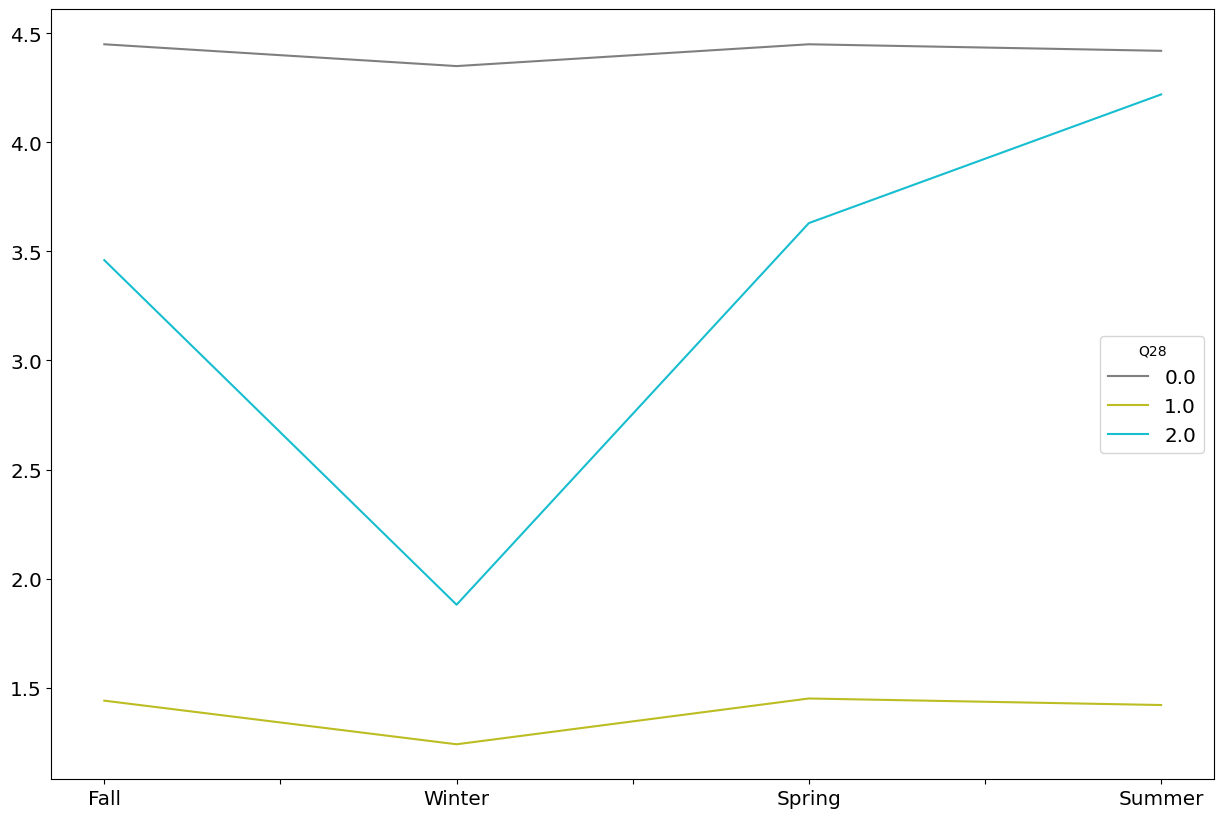

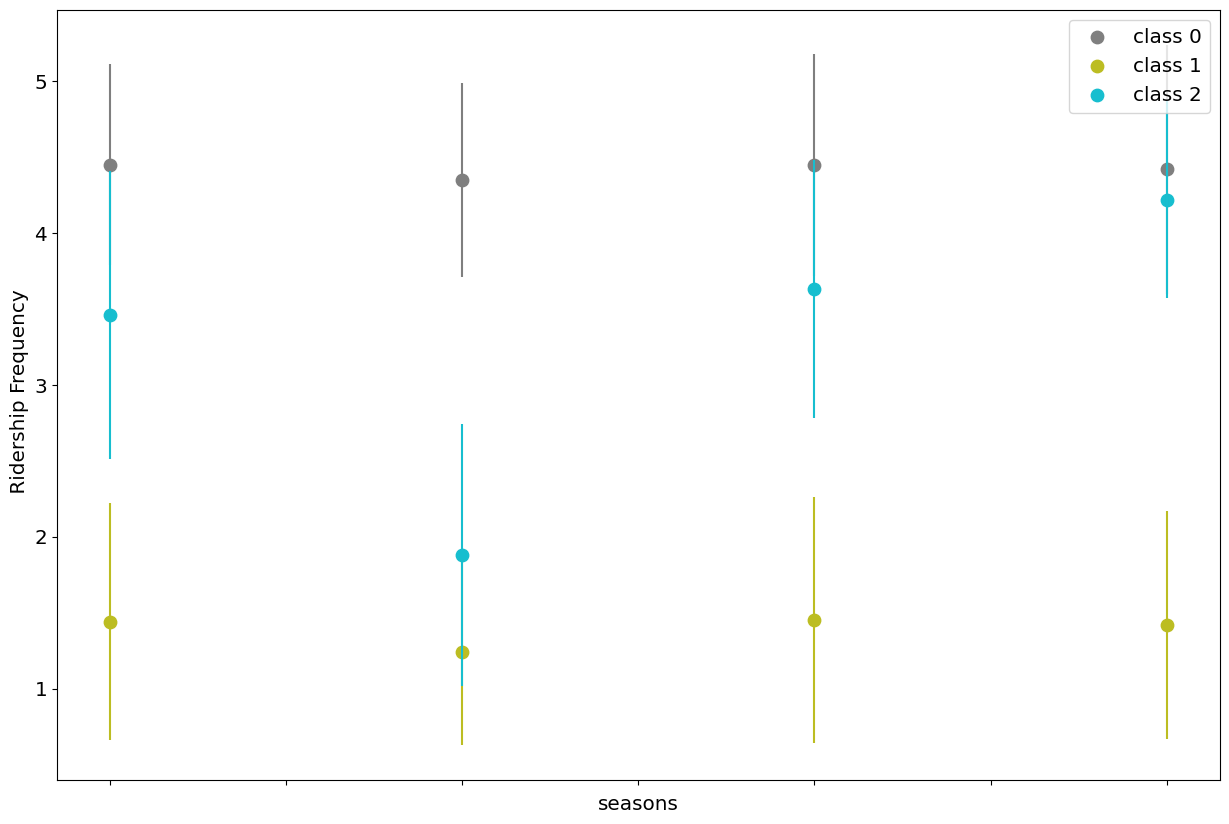

In [40]:

from sklearn.cluster import AgglomerativeClustering

# Parameters for this
n = 3
my_class = 'Q28'
seasons_values = list(seasons.values())
color_list = [color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'][-n:]]


# get all the relevant code into new dataframe (remove rows with Null values)
data_general_classification = data_general.copy()[list(seasons_values)+['index']].dropna().rename(columns={'index':'old_index'})


# Encoding
new_cols = [f'{d}_en' for d in seasons_values]
data_general_classification[new_cols] = data_general_classification[seasons_values].apply(lambda row: [frequency_dic[y] for y in row],
                                                                          axis=1, result_type='expand')


# Classification using AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=n)
clas_res = cluster.fit_predict(data_general_classification[new_cols].to_numpy())

# --- for test only---
# import collections
# counts = collections.Counter(clas_res)
# --- for test only---

data_general_classification[my_class] = clas_res

# for analysis
sum_data = []
std_data = []
data_to_analysis = data_general_classification.drop(columns=seasons_values+['old_index'])

# visualization
for x in range(n):
    class_data = data_to_analysis[data_to_analysis[my_class] == x]
    # show the mean for each group and for each season
    class_data_describe = class_data.describe()
    print(class_data_describe)
    sum_data.append(list(round(class_data_describe.loc['mean'], 2).values))
    std_data.append(list(round(class_data_describe.loc['std'], 2).values))

# mean
# sum_data
# std_data
DataFrame(data=sum_data, columns=list(seasons.values()) + [my_class]).set_index(my_class).T.plot(color=color_list)

# mean + std
mean_df = DataFrame(data=sum_data, columns=list(seasons.values()) + [my_class]).set_index(my_class).T
std_df = DataFrame(data=std_data, columns=list(seasons.values()) + [my_class]).set_index(my_class).T
std_df.columns = range(n)

for i in range(n):
    data_prep = mean_df[i].reset_index(drop=True).reset_index().rename(columns={'index': 'x', i: 'y'})
    if i == 0:
        ax = data_prep.plot(kind='scatter', x='x', y='y', color=color_list[i],
                            yerr=std_df[i].reset_index(drop=True).reset_index()[i], label=f'class {i}',s=80,
                            xlabel='Seasons', ylabel=' Ridership Frequency')
    else:
        data_prep.plot(kind='scatter', x='x', y='y', color=color_list[i],
                       yerr=std_df[i].reset_index(drop=True).reset_index()[i], ax=ax, label=f'class {i}',s=80,
                       xlabel='seasons', ylabel=' Ridership Frequency')
    ax.set_xticklabels([])
plt.legend()
plt.show()

In [43]:
data_to_analysis

,Fall_en,Winter_en,Spring_en,Summer_en,Q28
0,2,1,2,5,2
1,5,5,5,5,0
2,3,3,4,5,2
3,4,1,4,5,2
4,5,5,5,5,0
...,...,...,...,...,...
1813,1,1,1,1,1
1816,3,3,3,3,0
1817,5,5,5,5,0
1818,4,3,4,4,2


In [9]:
# merge the results into our database and save it into a new file
merge_q = merge_q26.set_index('index')
merge_q[my_class] =data_general_classification.set_index('old_index')[my_class]
# calculate decades for age
merge_q['Q34_1'] = merge_q['Q34'].dropna().map(lambda x:str(int(x/10)*10) +'s')
merge_q.to_csv(f'{project_folder}/new_data/new_data_2.csv')

NameError: name 'merge_q26' is not defined

In [21]:
q_num = 'Q29'
res_reg[q_num]
q = questions_to_examine_1.loc[q_num][0]

,Q29,count,per
2,"Recreation or exercise (e.g., cycling in your ...",721,42.0
3,"Transportation (e.g., commuting to school or w...",542,31.0
1,"Equal mix of recreation, exercise, and transpo...",455,26.0
0,Don’t know/not sure,10,1.0


In [35]:
q_num = 'Q30'
res_reg[q_num]
q = questions_to_examine_1.loc[q_num][0]
q

,Q30,count,per
0,"Car, as a driver (e.g., personal vehicle, cars...",611,35.0
2,"Cycle, personal bicycle (e.g., own a second bi...",291,17.0
11,Walk,282,16.0
5,Didn’t make those trips,221,13.0
10,"Transit (e.g., bus/rail)",163,9.0
1,"Car, as a passenger (e.g., given rides by frie...",57,3.0
3,"Cycle, public bike share",27,2.0
6,Don’t know/not sure,29,2.0
4,"Cycle, rental bicycle",11,1.0
7,"Micro mobility (e.g., e-scooter, e-unicycle, e...",9,1.0


'Thinking about the trips you made with the stolen/damaged bicycle, what transportation mode did you most often use to make those trips while your bicycle was unavailable?'

In [23]:
q_num = 'Q31'
res_reg[q_num]
q = questions_to_examine_1.loc[q_num][0]
q

,Q31,count,per
0,About the same / no change,852,49.0
2,Less often,511,30.0
1,I stopped cycling,263,15.0
3,More often,104,6.0


'Compared to before the theft, what best describes your overall cycling activity after your stolen bicycle (or part) was recovered, replaced, or abandoned? Did you cycle…'

In [24]:
q_num = 'Q32'
q = questions_to_examine_1.loc[q_num][0]
most_pop = res32_33[0].iloc[0]
text = f"{q_num} - {q}"
display(Markdown(text))
text = f"<h4>Results</h4><ul><li>the answer with the highest  frequency is:</li></ul>"
display(Markdown(text))
most_pop
q_num = 'Q33'
q = questions_to_examine_1.loc[q_num][0]
most_pop = res32_33[1].iloc[0]
text = f"{q_num} - {q}"
display(Markdown(text))
len_all = len(data_general)
percentage_of_ans = int(round((len_all - data_general[q_num].isna().sum()) / len_all * 100))
text = f"<h4>Results</h4><ul><li>only {percentage_of_ans}% answer this question.</li><li>the answer with the highest  frequency is :</li></ul>"
display(Markdown(text))
most_pop

text = "<h4>Next analysis</h4><ul> <li>group choices</li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>"
display(Markdown(text))
res32_33[0]
res32_33[1]

Q32 - What were the main reasons you cycled less often or not at all? (Select up to 3) - Selected Choice

<h4>Results</h4><ul><li>the answer with the highest  frequency is:</li></ul>

count    307.0
per       25.0
Name: I couldn’t recover my bicycle and didn’t replace it due to cost or other reason, dtype: float64

Q33 - What were the main reasons you cycled more often? (Select up to 3) - Selected Choice

<h4>Results</h4><ul><li>only 6% answer this question.</li><li>the answer with the highest  frequency is :</li></ul>

count    49.0
per      26.0
Name: My new bicycle was more capable, comfortable to ride, or better suited to my travel needs, dtype: float64

<h4>Next analysis</h4><ul> <li>group choices</li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>

,count,per
question,,
I couldn’t recover my bicycle and didn’t replace it due to cost or other reason,307,25.0
There might not be a safe place to park my bicycle at the places I go,216,18.0
Became accustomed to travelling with a different mode,118,10.0
Other (please specify):,125,10.0
My new bicycle isn’t as capable or comfortable to ride,113,9.0
I don’t have a safe place to store my bicycle at home,94,8.0
"High-security locks or secure parking locations involve a great deal of effort, inconvenience, or difficulty to access my bicycle",89,7.0
"My cycling equipment/accessories/gear (e.g., panniers, lock, lights, rack, basket) necessary to make my usual cycling trips were stolen or damaged",75,6.0
Not riding has made me too out of shape to make my usual cycling trips,47,4.0


,count,per
question,,
"My new bicycle was more capable, comfortable to ride, or better suited to my travel needs",49,26.0
Reasons unrelated to the theft,34,18.0
"I was motivated to purchase new cycling equipment/accessories/gear (e.g., panniers, lock, lights, rack, basket, cycle computer, rain gear) to make more frequent cycling trips, have more enjoyable trips, or visit new places",27,14.0
"Upgraded the quality of lock I use and/or used another type of anti-theft device, so I was less worried about theft",24,13.0
Other (please specify):,25,13.0
"I added my bicycle to a registry/recovery system, so I was less worried about theft",11,6.0
I replaced my stolen bicycle with an e-bike,6,3.0
"My replacement bicycle was used or less expensive than the stolen bike, so I was less worried about theft",6,3.0
"My recovered bicycle was cosmetically damaged, or I made it look unattractive, so I was less worried about theft",3,2.0


In [25]:
text = f"<h4>Research Questions</h4><ul><li>The change in behavior following theft (Q25 - Q27 and Q30- Q33). These questions should be cross tabulated with demographic, bike type and Q28 different  personal profile type and Q29</li></ul>"
display(Markdown(text))

<h4>Research Questions</h4><ul><li>The change in behavior following theft (Q25 - Q27 and Q30- Q33). These questions should be cross tabulated with demographic, bike type and Q28 different  personal profile type and Q29</li></ul>

In [26]:
# list with question number
# add Q
questions = [f'Q{num}' for num in list(range(25, 28)) + list(range(30, 34))]
# get the tables from the dic
res_25
res_26
res_q27
# present them


,Q25,count,per
2,"​Yes, and I replaced it with exactly what was ...",828,46.0
0,No,558,31.0
1,"Yes, but the replacement was something cheaper",426,24.0


(             count
 num_of_days       
 30             167
 60             140
 90              83
 14              64
 180             54
 ...            ...
 161              1
 182              1
 185              1
 195              1
 1460             1
 
 [99 rows x 1 columns],
                  0
 count  1037.000000
 mean     98.671167
 std     142.170234
 min       0.000000
 25%      20.000000
 50%      49.000000
 75%     120.000000
 max    1460.000000,
 {'no_action_yet': (49, 4.511970534069982)},
          0
 0       30
 1       30
 2       30
 3       30
 4       30
 ...    ...
 1032   161
 1033   182
 1034   185
 1035   195
 1036  1460
 
 [1037 rows x 1 columns])

(             count
 num_of_days       
 7                8
 14               5
 60               3
 3                2
 5                2
 0                1
 45               1
 324              1
 160              1
 120              1
 20               1
 42               1
 21               1
 1                1
 19               1
 15               1
 360              1,
                 0
 count   32.000000
 mean    45.281250
 std     85.462776
 min      0.000000
 25%      7.000000
 50%     14.000000
 75%     42.750000
 max    360.000000,
 {'no_action_yet': (1, 3.0303030303030303)},
       0
 0     7
 1     7
 2     7
 3     7
 4     7
 5     7
 6     7
 7     7
 8    14
 9    14
 10   14
 11   14
 12   14
 13   60
 14   60
 15   60
 16    3
 17    3
 18    5
 19    5
 20    0
 21   45
 22  324
 23  160
 24  120
 25   20
 26   42
 27   21
 28    1
 29   19
 30   15
 31  360)

### Cross Tabulation

#### General

In [24]:
# Update form year to age groups
merge_q['age'] = 2022 - merge_q['Q34']
groups_name = [
    "Children (<13)",
     "Adolescents (13-17)",
     "Young adults (18-24)",
     "Adults (25-34)",
     "Adults (35-44)",
     "Adults (45-54)",
     "Adults (55-64)",
     "Older adults (>64)"
 ]
def get_age_groups(num):
    if num <13:
        return groups_name[0]
    if num <18:
        return groups_name[1]
    if num < 25:
        return groups_name[2]
    if num < 35:
        return groups_name[3]
    if num < 45:
        return groups_name[4]
    if num < 55:
        return groups_name[5]
    if num < 65:
        return groups_name[6]
    return groups_name[7]
merge_q['age_groups'] = merge_q['age'].apply(get_age_groups)
merge_q['age_groups'].value_counts()
merge_q.to_csv(f'{project_folder}/new_data/new_data_2.csv')

Adults (25-34)          497
Adults (35-44)          450
Adults (45-54)          311
Older adults (>64)      268
Adults (55-64)          178
Young adults (18-24)     94
Adolescents (13-17)      18
Children (<13)            5
Name: age_groups, dtype: int64

In [20]:
merge_q = pd.read_csv(f'{project_folder}/new_data/new_data_2.csv')

In [26]:
questions_to_analysis = ['Q2','Q10','Q12','Q13','Q14','Q15','Q18','Q24','Q25', 'Q26_new', 'Q28', 'Q29', 'Q30', 'Q31','age_groups','Q35','Q36','Q37','Q38','Q39','country','city']
special_reindex= ['Q13','Q15','Q30','Q31','Q36','Q37','Q38','Q39','city','age_groups']

# reindex general
reindex_dic={val:DataFrame(merge_q[val].unique()).dropna().sort_values(by=0,ascending=1)[0].to_list() for val in questions_to_analysis if val not in special_reindex}

# reindex the options in q13
q13= 'Q13'
df = DataFrame(merge_q[q13].unique()).dropna().sort_values(by=0,ascending=0).reset_index(drop=True)
reindex_dic[q13] = pd.concat([df.iloc[0], df.iloc[6], df.iloc[4],df.iloc[8],df.iloc[7],df.iloc[5],df.iloc[1:4].sort_values(by=0,ascending=1)])[0].to_list()

# reindex the options in q15 - by frequency
q15= 'Q15'
reindex_dic[q15] = merge_q.groupby(q15).count().sort_values(by='index',ascending=False).index.to_list()

# reindex the options in q30
q30= 'Q30'
df= DataFrame(merge_q[q30].unique()).dropna().sort_values(by=0,ascending=1).reset_index(drop=True)
reindex_dic[q30]= pd.concat([df.iloc[:2], df.iloc[9:11], df.iloc[7:9],df.iloc[2:5],df.iloc[-1],df.iloc[5:7]])[0].to_list()

# reindex the options in q39 - by the
q31= 'Q31'
df= DataFrame(merge_q[q31].unique()).dropna().sort_values(by=0,ascending=1)
reindex_dic[q31] = pd.concat([df.iloc[1:3], df.iloc[0], df.iloc[-1]])[0].to_list()

# reindex the options in q36
q36 = 'Q36'
df= DataFrame(merge_q[q36].unique()).dropna().sort_values(by=0,ascending=0)
temp_2 = df.iloc[3:7].sort_values(by=0,ascending=1)
temp_3 = df.iloc[7:9].sort_values(by=0,ascending=1)
reindex_dic[q36] = pd.concat([df.iloc[0],temp_2,temp_3,df.iloc[-1],df.iloc[1:3]])[0].to_list()


# reindex the options in q37
numbers = {
    "zero":0,
     "one": 1,
     "two": 2,
     "three": 3,
     "four":4,
    "five":5
 }
def def_reindex_q37(a):
    reindex_q37[numbers.get(a.split()[0].lower(),6)] = a

q37= 'Q37'
reindex_q37 = [0 for b in range(7)]
df= DataFrame(merge_q[q37].unique()).dropna().sort_values(by=0,ascending=0)
_ = df[0].apply(def_reindex_q37)
reindex_dic[q37] =reindex_q37

# reindex the options in q38
q38= 'Q38'
df= DataFrame(merge_q[q38].unique()).dropna().sort_values(by=0,ascending=1)
reindex_dic[q38] = pd.concat([df.iloc[-2], df.iloc[3], df.iloc[-1],df.iloc[:3],df.iloc[4]])[0].to_list()

# reindex the options in q39 - by frequency
q39= 'Q39'
reindex_dic[q39]= merge_q.groupby(q39).count().sort_values(by='index',ascending=False).index.to_list()

# reindex the options in age_groups
qage_groups= 'age_groups'
reindex_dic[qage_groups]= groups_name


In [36]:
reindex_dic

{'Q2': ['A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)',
  'Entire bicycle (i.e., frame and components) '],
 'Q10': ['Don’t know/not sure', 'No ', 'Yes '],
 'Q12': ['Don’t know/not sure ', 'I prefer to not answer', 'No ', 'Yes '],
 'Q14': ['Yes, with pedal-assist (motor activates only while pedalling) ',
  'Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)',
  '\u200bNo '],
 'Q18': ['No', 'Yes (including if damaged) '],
 'Q24': ['Don’t know/not sure',
  'Repairable– bicycle was damaged and repairs were required before being rideable',
  'Rideable– bicycle was safe to operate and immediately usable',
  'Salvage/junk– bicycle was not rideable or repairable'],
 'Q25': ['No',
  'Yes, but the replacement was something cheaper',
  '\u200bYes, and I replaced it with exactly what was stolen or something more expensive '],
 'Q26_new': [-1.0, 7.0, 14.0, 30.0, 60.0, 90.0, 180.0, 365.0, 730.0],
 'Q28': [0.0, 1.0, 2.0],


In [25]:
def my_cross_tab(array_main,array_sec,local_db,analysis_name):
    r"""
    cross tabulation between all the questions in array_main and the questions in array_sec in local_db
    :param local_db:
    :param array_main:
    :param array_sec:
    :return:
    """
    data_list={}
    for val in array_main:
        re_index_row = reindex_dic[val]
        for val_2 in array_sec:
            if val== val_2:
                continue
            re_index_col = reindex_dic[val_2]
            data_list[f'{questions[val]}_{questions[val_2]}_per'] = round(pd.crosstab(index=local_db[val], columns=local_db[val_2], normalize='columns'),2).reindex(columns=re_index_col,index= re_index_row) * 100
            data_list[f'{questions[val]}_{questions[val_2]}_nums'] =pd.crosstab(index=local_db[val], columns=local_db[val_2]).reindex(columns=re_index_col,index= re_index_row)
    with pd.ExcelWriter(f"output_2/{analysis_name}.xlsx") as writer:
        [item[1].to_excel(writer, sheet_name=item[0]) for item in data_list.items()]


#### With Demographic questions

In [32]:
demographic_0 = ['age_groups','Q35','Q36','Q37','Q38','Q39']
demographic_1 = ['age_groups','Q35','Q36','Q37','Q38','Q39']
data_list = my_cross_tab( demographic_0 ,demographic_1,merge_q,'demographic_demographic')
# for data_res in data_list.values():
#     data_res

In [33]:
habit_q = ['Q25', 'Q26_new', 'Q28', 'Q29', 'Q30', 'Q31']
demographic = ['age_groups','Q35','Q36','Q37','Q38','Q39']
my_cross_tab( habit_q,demographic,merge_q,'habit_demographic')

#### With bike type

In [34]:
bike_type = ['Q2','Q10','Q12','Q13','Q14','Q15']
my_cross_tab( habit_q,bike_type,merge_q,'habit_bike_type')

#### Internal and Recovery


In [35]:
habit_q2 = ['Q25', 'Q26_new', 'Q30', 'Q31']
rec_internal = ['Q18','Q24','Q28','Q29']
my_cross_tab( habit_q2,rec_internal,merge_q,'habit_habit_recovery')


In [36]:
country = ['country']
my_cross_tab( habit_q,country,merge_q,'country')

In [37]:
city ='city'
city_arry = [city]
city_list = ['San Francisco','Los Angeles','Seattle','Edmonton','Calgary']
reindex_dic[city ] = city_list
data_city = merge_q[merge_q[city].isin(city_list)]
my_cross_tab( habit_q,city_arry,data_city,'city')

In [6]:
## Some general statistic to update
merge_q = pd.read_csv(f'{project_folder}/new_data/new_data_2.csv')

In [23]:
# Create table of age
cnt = DataFrame(merge_q.value_counts('age_groups').rename('Count'))
cnt['Pct.'] = (merge_q.value_counts('age_groups', normalize=True)).round(2)
cnt.reindex(groups_name).to_csv(r'output_2/age.csv')

age_groups
Adults (25-34)                                                  497
Adults (35-44)                                                  450
Adults (45-54)                                                  311
Older adults                                                    268
Adults (55-64)                                                  178
Young adults                                                     94
Adolescents                                                      18
Children                                                          5
Pct.              age_groups
Adults (25-34)    27
Adults (35-44)...
Name: Count, dtype: object